In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)
import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download ForestCoverType dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    


File already exists.


# Load data and split
Same split as in original paper

In [4]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])


In [5]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [7]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [8]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


# Training

In [9]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [12]:
max_epochs = 500 if not os.getenv("CI", False) else 2

In [13]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=1024, virtual_batch_size=64
) 

epoch 0  | loss: 0.66672 | train_accuracy: 0.72043 | valid_accuracy: 0.71865 |  0:01:10s
epoch 1  | loss: 0.70018 | train_accuracy: 0.7067  | valid_accuracy: 0.70567 |  0:02:21s
epoch 2  | loss: 0.67369 | train_accuracy: 0.72159 | valid_accuracy: 0.72006 |  0:03:29s
epoch 3  | loss: 0.65157 | train_accuracy: 0.72731 | valid_accuracy: 0.72539 |  0:04:36s
epoch 4  | loss: 0.6345  | train_accuracy: 0.73126 | valid_accuracy: 0.72948 |  0:05:43s
epoch 5  | loss: 0.61923 | train_accuracy: 0.74338 | valid_accuracy: 0.74118 |  0:06:51s
epoch 6  | loss: 0.60091 | train_accuracy: 0.75712 | valid_accuracy: 0.75479 |  0:07:59s
epoch 7  | loss: 0.58222 | train_accuracy: 0.71993 | valid_accuracy: 0.71941 |  0:09:03s
epoch 8  | loss: 0.61459 | train_accuracy: 0.74725 | valid_accuracy: 0.7463  |  0:10:05s
epoch 9  | loss: 0.6084  | train_accuracy: 0.74018 | valid_accuracy: 0.7383  |  0:11:05s
epoch 10 | loss: 0.58382 | train_accuracy: 0.77283 | valid_accuracy: 0.7698  |  0:12:06s
epoch 11 | loss: 0.56

epoch 93 | loss: 0.22027 | train_accuracy: 0.94245 | valid_accuracy: 0.93029 |  1:38:48s
epoch 94 | loss: 0.22061 | train_accuracy: 0.93719 | valid_accuracy: 0.9247  |  1:39:52s
epoch 95 | loss: 0.22168 | train_accuracy: 0.93906 | valid_accuracy: 0.92753 |  1:40:56s
epoch 96 | loss: 0.22121 | train_accuracy: 0.94211 | valid_accuracy: 0.93062 |  1:42:04s
epoch 97 | loss: 0.22429 | train_accuracy: 0.93611 | valid_accuracy: 0.92475 |  1:43:13s
epoch 98 | loss: 0.22502 | train_accuracy: 0.93963 | valid_accuracy: 0.92769 |  1:44:21s
epoch 99 | loss: 0.22057 | train_accuracy: 0.94214 | valid_accuracy: 0.92915 |  1:45:30s
epoch 100| loss: 0.21679 | train_accuracy: 0.94168 | valid_accuracy: 0.92907 |  1:46:38s
epoch 101| loss: 0.21658 | train_accuracy: 0.94306 | valid_accuracy: 0.9306  |  1:47:47s
epoch 102| loss: 0.215   | train_accuracy: 0.94217 | valid_accuracy: 0.92961 |  1:48:56s
epoch 103| loss: 0.21419 | train_accuracy: 0.9374  | valid_accuracy: 0.92549 |  1:50:04s
epoch 104| loss: 0.21

epoch 186| loss: 0.18459 | train_accuracy: 0.95454 | valid_accuracy: 0.93984 |  3:26:42s
epoch 187| loss: 0.18397 | train_accuracy: 0.95614 | valid_accuracy: 0.94044 |  3:27:50s
epoch 188| loss: 0.18478 | train_accuracy: 0.95355 | valid_accuracy: 0.93908 |  3:29:00s
epoch 189| loss: 0.18513 | train_accuracy: 0.9541  | valid_accuracy: 0.93913 |  3:30:10s
epoch 190| loss: 0.1864  | train_accuracy: 0.95328 | valid_accuracy: 0.93865 |  3:31:18s
epoch 191| loss: 0.19991 | train_accuracy: 0.95273 | valid_accuracy: 0.93827 |  3:32:24s
epoch 192| loss: 0.18642 | train_accuracy: 0.95129 | valid_accuracy: 0.937   |  3:33:32s
epoch 193| loss: 0.1875  | train_accuracy: 0.95006 | valid_accuracy: 0.93529 |  3:34:42s
epoch 194| loss: 0.1848  | train_accuracy: 0.95476 | valid_accuracy: 0.94013 |  3:35:52s
epoch 195| loss: 0.18374 | train_accuracy: 0.95643 | valid_accuracy: 0.94138 |  3:37:02s
epoch 196| loss: 0.18526 | train_accuracy: 0.95612 | valid_accuracy: 0.9412  |  3:38:10s
epoch 197| loss: 0.18

epoch 279| loss: 0.16858 | train_accuracy: 0.96152 | valid_accuracy: 0.94529 |  5:13:37s
epoch 280| loss: 0.16828 | train_accuracy: 0.95824 | valid_accuracy: 0.94234 |  5:14:49s
epoch 281| loss: 0.16692 | train_accuracy: 0.96191 | valid_accuracy: 0.94533 |  5:16:03s
epoch 282| loss: 0.16849 | train_accuracy: 0.96114 | valid_accuracy: 0.94505 |  5:17:13s
epoch 283| loss: 0.16708 | train_accuracy: 0.96005 | valid_accuracy: 0.94365 |  5:18:27s
epoch 284| loss: 0.16678 | train_accuracy: 0.95957 | valid_accuracy: 0.94359 |  5:19:39s
epoch 285| loss: 0.16595 | train_accuracy: 0.95998 | valid_accuracy: 0.94312 |  5:20:49s
epoch 286| loss: 0.16765 | train_accuracy: 0.96128 | valid_accuracy: 0.94431 |  5:22:02s
epoch 287| loss: 0.16697 | train_accuracy: 0.96185 | valid_accuracy: 0.94525 |  5:23:13s
epoch 288| loss: 0.16771 | train_accuracy: 0.9596  | valid_accuracy: 0.94325 |  5:24:25s
epoch 289| loss: 0.16605 | train_accuracy: 0.96189 | valid_accuracy: 0.94475 |  5:25:37s
epoch 290| loss: 0.16

epoch 372| loss: 0.15864 | train_accuracy: 0.96509 | valid_accuracy: 0.94776 |  7:01:24s
epoch 373| loss: 0.15673 | train_accuracy: 0.96369 | valid_accuracy: 0.94604 |  7:02:34s
epoch 374| loss: 0.15743 | train_accuracy: 0.96295 | valid_accuracy: 0.94582 |  7:03:45s
epoch 375| loss: 0.15887 | train_accuracy: 0.96474 | valid_accuracy: 0.94714 |  7:04:57s
epoch 376| loss: 0.15828 | train_accuracy: 0.95993 | valid_accuracy: 0.94231 |  7:06:08s
epoch 377| loss: 0.15772 | train_accuracy: 0.96418 | valid_accuracy: 0.94731 |  7:07:20s
epoch 378| loss: 0.1593  | train_accuracy: 0.96553 | valid_accuracy: 0.94717 |  7:08:30s
epoch 379| loss: 0.15794 | train_accuracy: 0.96422 | valid_accuracy: 0.94671 |  7:09:42s
epoch 380| loss: 0.15703 | train_accuracy: 0.96653 | valid_accuracy: 0.94933 |  7:10:54s
epoch 381| loss: 0.15884 | train_accuracy: 0.96413 | valid_accuracy: 0.94718 |  7:12:05s
epoch 382| loss: 0.15647 | train_accuracy: 0.96232 | valid_accuracy: 0.94442 |  7:13:17s
epoch 383| loss: 0.15

epoch 465| loss: 0.14999 | train_accuracy: 0.96638 | valid_accuracy: 0.94886 |  9:45:29s
epoch 466| loss: 0.14916 | train_accuracy: 0.96722 | valid_accuracy: 0.9487  |  9:48:05s
epoch 467| loss: 0.1509  | train_accuracy: 0.96907 | valid_accuracy: 0.95014 |  9:50:40s
epoch 468| loss: 0.14865 | train_accuracy: 0.96508 | valid_accuracy: 0.9474  |  9:53:17s
epoch 469| loss: 0.14994 | train_accuracy: 0.96637 | valid_accuracy: 0.94841 |  9:55:53s
epoch 470| loss: 0.15127 | train_accuracy: 0.96683 | valid_accuracy: 0.94902 |  9:58:29s
epoch 471| loss: 0.15077 | train_accuracy: 0.96742 | valid_accuracy: 0.94893 |  10:01:05s
epoch 472| loss: 0.14983 | train_accuracy: 0.96548 | valid_accuracy: 0.94715 |  10:03:41s
epoch 473| loss: 0.15037 | train_accuracy: 0.96409 | valid_accuracy: 0.94627 |  10:06:07s
epoch 474| loss: 0.15172 | train_accuracy: 0.96765 | valid_accuracy: 0.94906 |  10:07:15s
epoch 475| loss: 0.14934 | train_accuracy: 0.96643 | valid_accuracy: 0.94809 |  10:08:24s
epoch 476| loss:

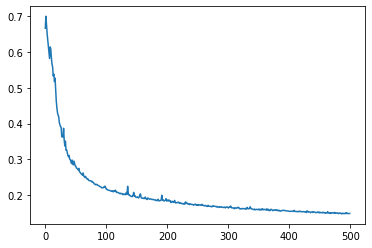

In [14]:
# plot losses
plt.plot(clf.history['loss'])

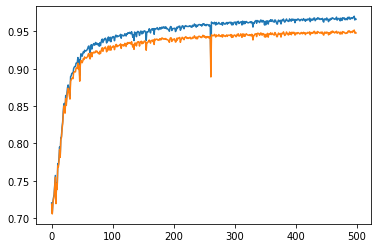

In [15]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions

In [16]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.9517416756488121
FINAL TEST SCORE FOR forest-cover-type : 0.95328003579942


In [17]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.95328003579942


# Save and load Model

In [18]:
# save state dict
saved_filename = clf.save_model('test_model')

Successfully saved model at test_model.zip


In [19]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

Device used : cuda
Device used : cuda


In [20]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.95328003579942


In [21]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [22]:
clf.feature_importances_

array([1.86089399e-01, 0.00000000e+00, 0.00000000e+00, 2.78212586e-08,
       4.80239382e-02, 1.49811623e-01, 8.29205110e-02, 8.69922247e-03,
       0.00000000e+00, 0.00000000e+00, 2.32432886e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.19636554e-03, 0.00000000e+00, 0.00000000e+00,
       9.15181515e-02, 0.00000000e+00, 0.00000000e+00, 1.42095954e-01,
       0.00000000e+00, 0.00000000e+00, 1.16707975e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.53749623e-01, 0.00000000e+00, 1.05484816e-01,
       0.00000000e+00, 0.00000000e+00])

# Local explainability and masks

In [23]:
explain_matrix, masks = clf.explain(X_test)

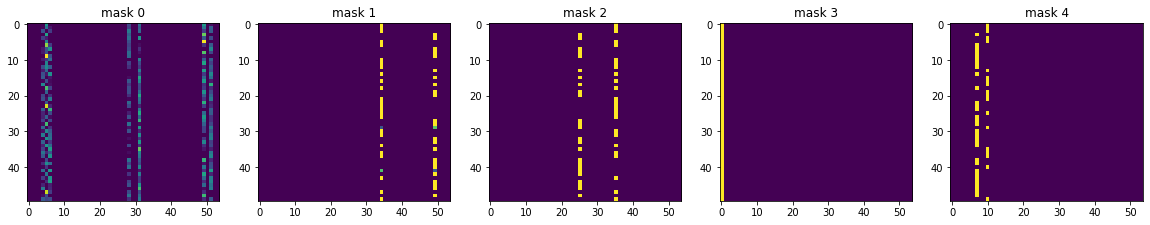

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [25]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [26]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

D:\Anaconda\envs\book-develop\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.74260
[10]	validation_0-mlogloss:0.90294
[20]	validation_0-mlogloss:0.63492
[30]	validation_0-mlogloss:0.52129
[40]	validation_0-mlogloss:0.46316
[50]	validation_0-mlogloss:0.42549
[60]	validation_0-mlogloss:0.40175
[70]	validation_0-mlogloss:0.38531
[80]	validation_0-mlogloss:0.37286
[90]	validation_0-mlogloss:0.36102
[100]	validation_0-mlogloss:0.34975
[110]	validation_0-mlogloss:0.33909
[120]	validation_0-mlogloss:0.32853
[130]	validation_0-mlogloss:0.32014
[140]	validation_0-mlogloss:0.31275
[150]	validation_0-mlogloss:0.30271
[160]	validation_0-mlogloss:0.29446
[170]	validation_0-mlogloss:0.28664
[180]	validation_0-mlogloss:0.27811
[190]	validation_0-mlogloss:0.26911
[200]	validation_0-mlogloss:0.26338
[210]	validation_0-mlogloss:0.25701
[220]	validation_0-mlogloss:0.25125
[230]	validation_0-mlogloss:0.24481
[240]	validation_0-mlogloss:0.23912
[250]	validation_0-mlogloss:0.23402
[260]	validation_0-mlogloss:0.22921
[270]	validation_0-mlogloss:0.22371
[28

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [27]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)

0.9589058778729419
0.9603452578676971
